In [328]:
## Import Some Libraries
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [329]:
class LoadModel:
    def __init__(self, file_path):
        with open(file_path, 'r') as f:
            model_data = json.load(f)
        
        layers = model_data['layers']
        n_layers = len(layers)
        
        self.weights = []
        self.biases = []
        self.activations = []
        
        for i in range(1, n_layers):
            layer = layers[i]
            
            if layer['tipe'] == 'hidden':
                n_neurons = layer['n_neuron']
                weight = np.array(layer['weight'])
                bias = np.array(layer['bias'])
                activation = layer['activation_function']
                
                self.weights.append(weight)
                self.biases.append(bias)
                self.activations.append(activation)
                
            elif layer['tipe'] == 'output':
                n_neurons = layer['n_neuron']
                weight = np.array(layer['weight'])
                bias = np.array(layer['bias'])
                activation = layer['activation']
                
                self.weights.append(weight)
                self.biases.append(bias)
                self.activations.append(activation)
                
    def get_weights(self):
        return self.weights
    
    def get_biases(self):
        return self.biases
    
    def get_activations(self):
        return self.activations
    
    def get_layer(self, layer):
        return self.weights[layer], self.biases[layer], self.activations[layer]
    
    def get_layer_weights(self, layer):
        return self.weights[layer]
    
    def get_layer_biases(self, layer):
        return self.biases[layer]
    
    def get_layer_activations(self, layer):
        return self.activations[layer]
    
    def get_model(self):
        return self.weights, self.biases, self.activations
    
    # print model per layer
    def print_model(self):
        for i in range(len(self.weights)):
            print('Layer', i+1)
            print('Weights:', self.weights[i])
            print('Biases:', self.biases[i])
            print('Activations:', self.activations[i])
            print('')

Instance: [3. 1.]
Layer 1 Calculated: [ 2.   0.3 -1.9]
Layer 2 Calculated: [0.]

Predictions: [[0]]
True Labels: [0]



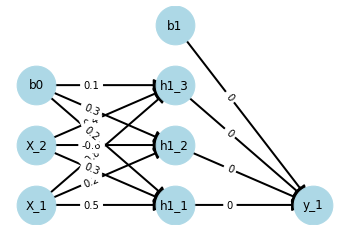

Accuracy: 100.00%


In [330]:
class FFNN:
    def __init__(self, model_path):
        self.model = LoadModel(model_path)
        self.weights = self.model.get_weights()
        self.biases = self.model.get_biases()
        self.activations = self.model.get_activations()

    def forward_propagation(self, X):
        input_layer = X
        n_layers = len(self.weights) + 1
        for i in range(n_layers - 1):
            dot_product = np.dot(input_layer, self.weights[i]) + self.biases[i]
            if self.activations[i] == 'relu':
                output_layer = np.maximum(0, dot_product)
            elif self.activations[i] == 'sigmoid':
                output_layer = 1 / (1 + np.exp(-dot_product))
            elif self.activations[i] == 'linear':
                output_layer = dot_product
            elif self.activations[i] == 'softmax':
                output_layer = np.exp(dot_product) / np.sum(np.exp(dot_product), axis=0)
            input_layer = output_layer

            print(f'Layer {i + 1} Calculated: {output_layer}')
        print()

        return output_layer

    def predict(self, X):
        if len(X.shape) == 1:
            return self.forward_propagation(X)
        else:
            predictions = []
            for instance in X:
                print(f'Instance: {instance}')
                predictions.append(self.forward_propagation(instance))
            return np.array(predictions)
        
    def accuracy(self, X, y_true):
        y_pred = self.predict(X)
        y_pred = (y_pred >= 0.5).astype(int)
        
        print(f'Predictions: {y_pred}')
        print(f'True Labels: {y_true}\n')

        return np.mean(y_pred == y_true)

    def sum_squared_error(self, y_calc, y_true):
        return np.sum(np.square(y_true - y_calc))
        
    def print_model(self):
        self.model.print_model()

    def draw_network(self):
        G = nx.DiGraph()

        pos = {}

        # add nodes
        input_nodes = [f'X_{i + 1}' for i in range(len(self.weights[0]))]
        G.add_nodes_from(input_nodes, layer='Input')
        G.add_nodes_from(['b0'], layer='Bias')
        for i in range(len(input_nodes)):   
            pos[f'X_{i + 1}'] = [0, i + 1]
        pos['b0'] = [0, len(self.weights[0]) + 1]

        hidden_nodes = []

        for i in range(len(self.weights) - 1):
            hidden_nodes.append([f'h{i + 1}_{j + 1}' for j in range(len(self.weights[i][0]))])
            G.add_nodes_from(hidden_nodes[i], layer='Hidden')
            G.add_nodes_from([f'b{i + 1}'], layer='Bias')
            for j in range(len(hidden_nodes[i])):
                pos[f'h{i + 1}_{j + 1}'] = [i + 1, j + 1]
            pos[f'b{i + 1}'] = [i + 1, len(self.weights[i][0]) + 1]

        output_nodes = [f'y_{i + 1}' for i in range(len(self.weights[-1][0]))]
        G.add_nodes_from(output_nodes, layer='Output')
        for i in range(len(output_nodes)):
            pos[f'y_{i + 1}'] = [len(self.weights), i + 1]

        # add edges
        for i in range(len(self.weights)):
            for j in range(len(self.weights[i])):
                for k in range(len(self.weights[i][j])):
                    if i == 0:
                        G.add_edge(input_nodes[j], hidden_nodes[i][k], weight=self.weights[i][j][k])
                        G.add_edge(f'b0', hidden_nodes[i][k], weight=self.biases[i][k])
                    elif i == len(self.weights) - 1:
                        G.add_edge(hidden_nodes[i - 1][j], output_nodes[k], weight=self.weights[i][j][k])
                        G.add_edge(f'b{i}', output_nodes[k], weight=self.biases[i][k])
                    else:
                        G.add_edge(hidden_nodes[i - 1][j], hidden_nodes[i][k], weight=self.weights[i][j][k])
                        G.add_edge(f'b{i}', hidden_nodes[i][k], weight=self.biases[i][k])

        # draw network
        edge_labels = nx.get_edge_attributes(G, 'weight')

        nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='lightblue')
        nx.draw_networkx_edges(G, pos, width=2, edge_color='black', arrows=True, arrowsize=25)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.60)
        nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
        plt.axis('off')
        plt.show()


# main function
def main():
    # load model
    filename = input("Enter the filename: ")
    model_path = filename + '.json'
    model = FFNN(model_path)

    # visualize input layer

    # linear
    X = np.array([[3.0, 1.0]])
    y_true = np.array([0])

    # # relu
    # X = np.array([[-1.0, 0.5]])
    # y_true = np.array([0])

    # # sigmoid
    # X = np.array([[0.2, 0.4]])
    # y_true = np.array([1])

    # # softmax
    # X = np.array([[1.0, 2.0]])
    # y_true = np.array([1])

    # # multilayer
    # X = np.array([[1.0, 0.0], [0.0, 1.0], [0.0, 0.0]])
    # y_true = np.array([1, 1, 1])

    # calculate accuracy
    accuracy = model.accuracy(X, y_true)

    model.draw_network()

    # # print predictions and accuracy
    print('Accuracy: {:.2f}%'.format(accuracy*100))

if __name__ == '__main__':
    main()
